# Digit Drawing and Recognizing Program

This notebook was used in the devolopement of this project. 

The aim of the project is to be able to clasify a digit drawn on the screen. 

This notebook is where we shall create the model that will be used for the casification.

The datasets used are the MNIST digits dataset and a self made dataset for which I collected samples from random strangers at my collage library.

The point of the self made dataset is to help asses the real world performance of the model after we train the model on the MNIST dataset. 
(The samples from the two datasets have certain variations)

P.S.: Use Pillow==9.5.0 with this notebook for compatablity with visualkeras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os

from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import Sequential, Model, Input

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
#from tensorflow.python.platform import tf_logging as logging
from keras.losses import SparseCategoricalCrossentropy
from keras.datasets import mnist
import visualkeras
from keras.utils import plot_model
from tensorflow import argmax


# Data Preparation

In [2]:
#Preparing Data from MNIST Dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

In [3]:
#Adding padding to the images help with image augmentation later
def pad28to32(arr):
    count = arr.shape[0]  
    new_array = np.empty((count, 32,32), dtype=int, order='C')

    for index in range (0, count):
        new_array[index] = np.pad(arr[index],2)
    return new_array

x_train_mnist = pad28to32(x_train_mnist)
x_test_mnist = pad28to32(x_test_mnist)

#Normalizing the data
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0

#Reshaping to specify gray sacle channel
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 32, 32, 1)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 32, 32, 1)

print(x_train_mnist.shape)
print(y_train_mnist.shape)
print(x_test_mnist.shape)
print(y_test_mnist.shape)

(60000, 32, 32, 1)
(60000,)
(10000, 32, 32, 1)
(10000,)


<Figure size 640x480 with 0 Axes>

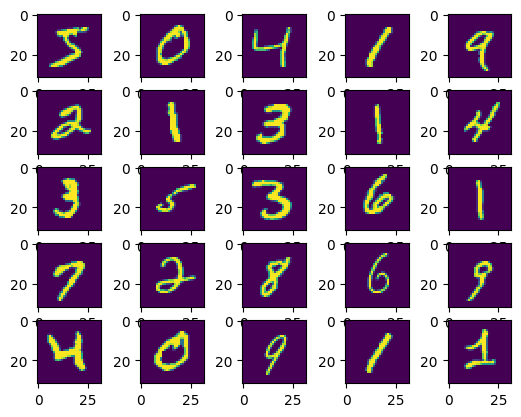

In [4]:
plt.figure()
f, ax = plt.subplots(5,5) 

for i in range (5):
    ax[0,i].imshow(x_train_mnist[i])
    ax[1,i].imshow(x_train_mnist[i+5])
    ax[2,i].imshow(x_train_mnist[i+10])
    ax[3,i].imshow(x_train_mnist[i+15])
    ax[4,i].imshow(x_train_mnist[i+20])
    
#plt.savefig('mnist_dataset.png')

In [4]:
#Preparing the selfmade testing dataset
df = pd.read_pickle('dataset.pkl')
x_test_sf = np.stack(df['image_data'])#.reshape(-1,32*32)
y_test_sf = np.stack(df['label'])

#Normalizing the data
x_test_sf = x_test_sf / 255.0

#Reshaping to specify gray sacle channel
x_test_sf = x_test_sf.reshape(x_test_sf.shape[0], 32, 32, 1)

print(x_test_sf.shape)
print(y_test_sf.shape)

(295, 32, 32, 1)
(295,)


<Figure size 640x480 with 0 Axes>

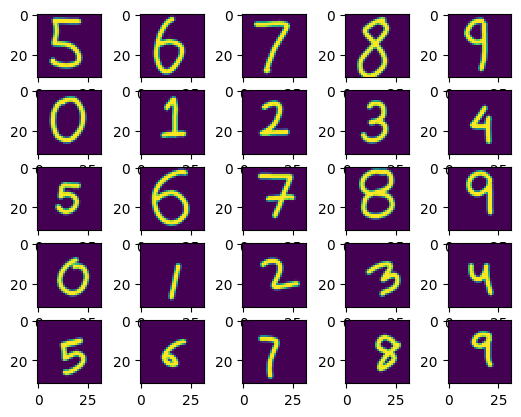

In [6]:
plt.figure()
f, ax = plt.subplots(5,5) 
for i in range (5):
    ax[0,i].imshow(x_test_sf[i+15])
    ax[1,i].imshow(x_test_sf[i+20])
    ax[2,i].imshow(x_test_sf[i+25])
    ax[3,i].imshow(x_test_sf[i+30])
    ax[4,i].imshow(x_test_sf[i+35])

#plt.savefig('handwriten_dataset.png')

# Performing Image Augmentation:

In [5]:
datagen = ImageDataGenerator(rotation_range=40, 
                             zoom_range=0.2, 
                             height_shift_range=0.2,
                             width_shift_range=0.2
                            )

(32, 32, 32, 1)


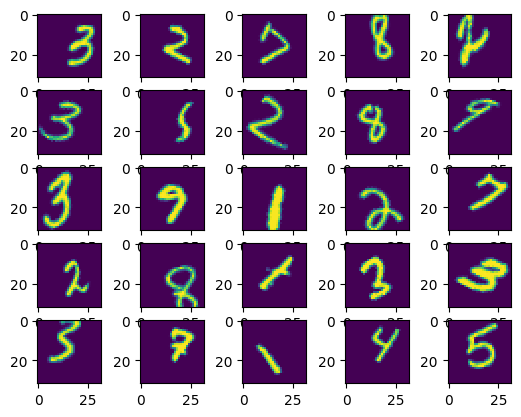

In [6]:
image_generator_mnist = datagen.flow(x_train_mnist.reshape(x_train_mnist.shape[0], 32, 32, 1), 
                                     y_train_mnist,
                                     seed=1) #Creats an itarator



print(image_generator_mnist[0][0].shape)

f, ax = plt.subplots(5,5) 
for i in range (5):
    ax[0,i].imshow(image_generator_mnist[0][0][i])
    ax[1,i].imshow(image_generator_mnist[0][0][i+5])
    ax[2,i].imshow(image_generator_mnist[0][0][i+10])
    ax[3,i].imshow(image_generator_mnist[0][0][i+15])
    ax[4,i].imshow(image_generator_mnist[0][0][i+20])
    
#plt.savefig('mnist_dataset_aug.png')

# making neural network model from mnist dataset with image augmentation:

In [61]:
#making neural network model from mnist dataset

# input layer
input = Input(shape=(32,32,1), name='Input')

# Hidden Layers
lay1 = Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(32,32,1), name='conv2d_1')(input)
lay2 = MaxPool2D((2, 2), name='max_pool2d_1')(lay1)
lay3 = Conv2D(64,kernel_size=(3, 3), activation='relu', name='conv2d_2')(lay2)
lay4 = MaxPool2D((2, 2), name='max_pool2d_2')(lay3)
lay5 = Conv2D(128,kernel_size=(3, 3), activation='relu', name='conv2d_3')(lay4)
lay6 = MaxPool2D((2, 2), name='max_pool2d_3')(lay5)
lay7 = Flatten(name='flatten')(lay6)
lay8 = Dense(32, activation='relu', name='dense_1')(lay7)
lay9 = Dropout(0.2, name='dropout_1')(lay8)
lay10= Dense(32, activation='relu', name='dense_2')(lay9)
lay11 = Dropout(0.2, name='dropout_2')(lay10)
lay12= Dense(32, activation='relu', name='dense_3')(lay11)
# output laer
out= Dense(10, activation = "softmax", name='Output')(lay12)

model = Model(inputs=input, outputs=out)

model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#model.summary()

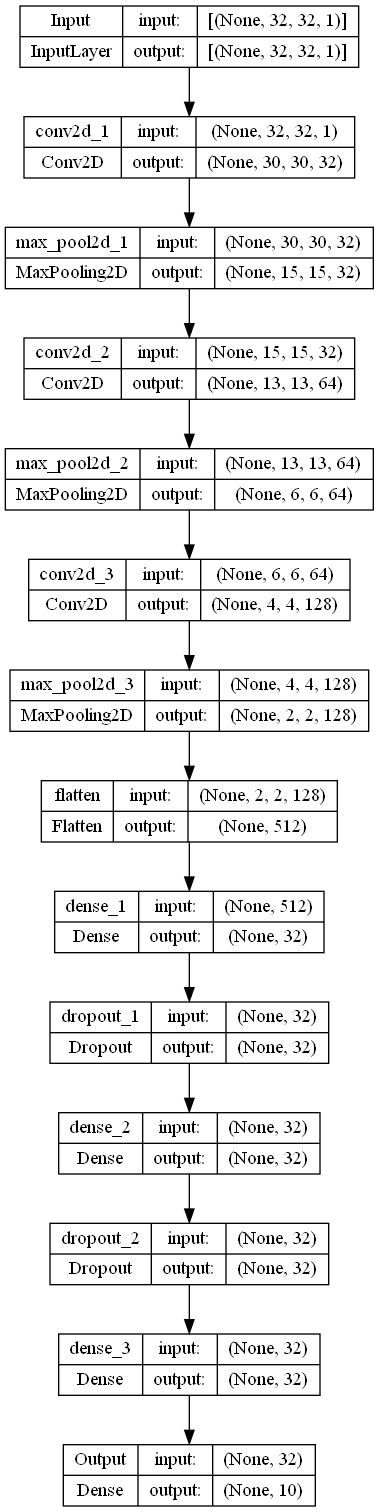

In [70]:
plot_model(model, to_file='model_mnist_aug_plot.png', show_shapes=True, show_layer_names=True)

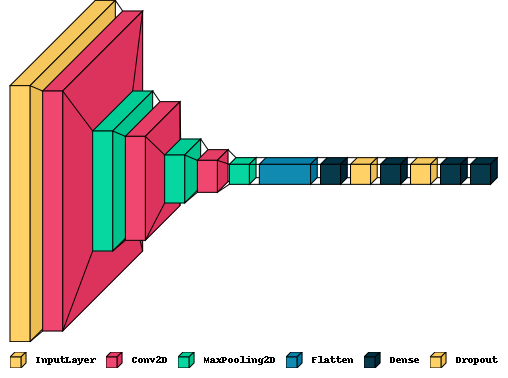

In [63]:
visualkeras.layered_view(model, legend=True, scale_xy=8 ,draw_volume=True)

In [64]:
checkpoint = ModelCheckpoint("best_mnist_aug.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

history = model.fit(image_generator_mnist, epochs=16, validation_data=(x_test_mnist,y_test_mnist), callbacks=[checkpoint])

#We use the mnist testing data for validation as we have no other use for it anyway

Epoch 1/16
1874/1875 [============================>.] - ETA: 0s - loss: 1.1556 - accuracy: 0.5921
Epoch 1: val_loss improved from inf to 0.17285, saving model to best_mnist_aug.hdf5
1875/1875 [==============================] - 65s 34ms/step - loss: 1.1553 - accuracy: 0.5922 - val_loss: 0.1729 - val_accuracy: 0.9455
Epoch 2/16


C:\Users\skyler\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1874/1875 [============================>.] - ETA: 0s - loss: 0.4361 - accuracy: 0.8671
Epoch 2: val_loss improved from 0.17285 to 0.10567, saving model to best_mnist_aug.hdf5
1875/1875 [==============================] - 63s 33ms/step - loss: 0.4361 - accuracy: 0.8671 - val_loss: 0.1057 - val_accuracy: 0.9700
Epoch 3/16
1875/1875 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.9155
Epoch 3: val_loss improved from 0.10567 to 0.06824, saving model to best_mnist_aug.hdf5
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2943 - accuracy: 0.9155 - val_loss: 0.0682 - val_accuracy: 0.9803
Epoch 4/16
1874/1875 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9329
Epoch 4: val_loss improved from 0.06824 to 0.06204, saving model to best_mnist_aug.hdf5
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2355 - accuracy: 0.9329 - val_loss: 0.0620 - val_accuracy: 0.9811
Epoch 5/16
1875/1875 [==========================

In [65]:
#getting the best model
model_best = load_model('best_mnist_aug.hdf5')

# Model Evaluation 

best val accuricy: 0.9884999990463257


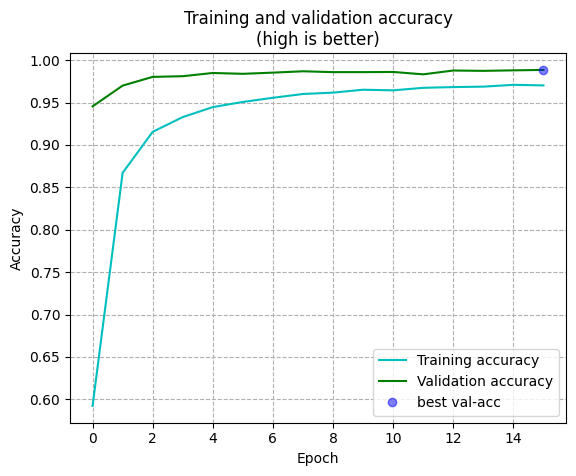

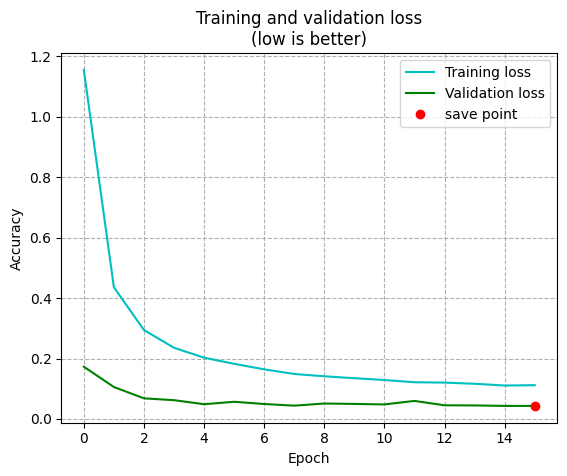

In [66]:
#plotting model training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

#saved = checkpoint.saved_epoch[-1]
best = val_accuracy.index(max(val_accuracy))

print("best val accuricy:",max(val_accuracy))

plt.plot(epochs, accuracy, 'c', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
#plt.plot([epochs[saved]], [val_accuracy[saved]], 'ro', label='save point', alpha = 0.5)
plt.plot([epochs[best]], [val_accuracy[best]], 'bo', label='best val-acc', alpha = 0.5)
plt.title('Training and validation accuracy\n(high is better)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(linestyle = '--')
plt.show()

plt.plot(epochs, loss, 'c', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot([epochs[best]], [val_loss[best]], 'ro', label='save point')
plt.title('Training and validation loss\n(low is better)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(linestyle = '--')
plt.show()

Model accuricy for the Mnist Test Set:

313/313 [==============================] - 2s 7ms/step


Text(0.5, 1.0, 'Accuracy: 98.84999990463257\nLoss: 4.3068792670965195')

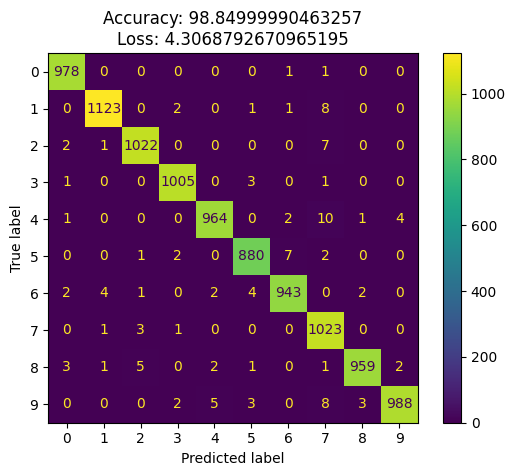

In [67]:
model_loss, model_accuracy = model_best.evaluate(x_test_mnist, y_test_mnist)

title = "Accuracy: "+ str(model_accuracy*100)+"\nLoss: "+str(model_loss*100)

y_pred = model_best.predict(x_test_mnist)
y_pred = argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_mnist, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
cm_display.ax_.set_title(title)
#plt.savefig('mnist_augVSmnist.png')

Model accuricy for the Self Made Test Set:

10/10 [==============================] - 0s 8ms/step


Text(0.5, 1.0, 'Accuracy: 98.9830493927002\nLoss: 4.714439436793327')

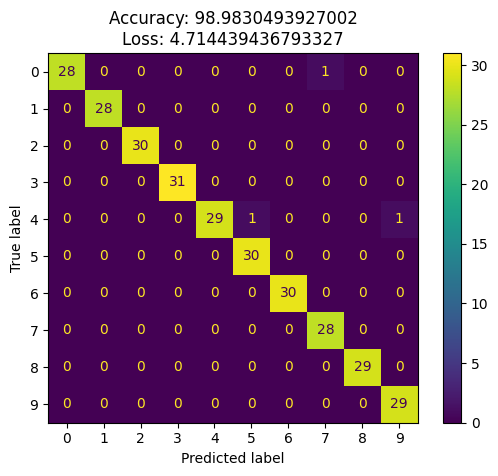

In [68]:
#Model tested on selfmade test dataset
model_loss, model_accuracy = model_best.evaluate(x_test_sf, y_test_sf)

title = "Accuracy: "+ str(model_accuracy*100)+"\nLoss: "+str(model_loss*100)

y_pred = model_best.predict(x_test_sf)
y_pred = argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_sf, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
cm_display.ax_.set_title(title)
#plt.savefig('mnist_augVShr.png')